In [145]:
import requests
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas_profiling as pp
from ratelimit import limits, RateLimitException, sleep_and_retry
from backoff import on_exception, expo
from local.config import core

In [84]:
# CORE API 3.0.0 BETA #

apikey = core.api_key

@sleep_and_retry
@limits(calls=4, period=110)
def query_api(query, scrollId=None):
    
    headers={"Authorization":"Bearer "+apikey}
    search_url = "https://api.core.ac.uk/v3/search/works"
    
    if not scrollId:
        response = requests.get(f"{search_url}?q={query}&limit=75&scroll=true",headers=headers)
    else:
        response = requests.get(f"{search_url}?q={query}&limit=75&scrollId={scrollId}",headers=headers)        
    
    headers = response.headers
    status_code = response.status_code
    print(f"Code: {status_code} | RateLimit: {headers['X-RateLimit-Remaining']} / {headers['X-RateLimit-Limit']} | Retry: {headers['X-RateLimit-Retry-After']}")
        
    hit = response.json()
    
    if "results" in hit:
        for element in hit["results"]: 
            if "fullText" in element:
                del element["fullText"]

    return hit, status_code

def scroll(query):
    allResults = []
    scrollId = None
    
    result, status_code = query_api(query)
    
    scrollId = result["scrollId"]
    totalHits = int(result["totalHits"])
    hitCount = int(result["offset"]) + int(result["limit"])
    allResults.append(result["results"])
    print(f"{hitCount} < {totalHits}")
    
    while (scrollId is not None) & (hitCount < totalHits):
        result, status_code = query_api(query, scrollId=scrollId)
        
        if "results" in result:
            scrollId = result["scrollId"]
            hitCount = hitCount + int(result["limit"])
            print(f"{hitCount} < {totalHits}")
            allResults.append(result["results"])
        elif status_code == 500:
            continue
        else:
            break
    
    return allResults

def clean_results(results):
    
    
    def parse_journal_name(row):
        for x in row:
            if len(x) > 0:
                return x["title"]
            else:
                return "N/A"

    def parse_identifiers(row):
        for x in row:
            if len(x) > 0:
                return x["identifiers"]
            else:
                return "N/A"
        
    def parse_identifiers_issn(row):
        id_array = []
        if row is not None:
            for x in row:
                if not x.startswith("issn"):
                    id_array.append(x)

            return id_array

    results = [item for sublist in results for item in sublist]

    keep_col = ["id","magId","oaiIds","doi","documentType","title","abstract","publisher","yearPublished","journals","dataProviders","identifiers","authors"]

    df = pd.DataFrame(results).loc[:,keep_col]
    df["lcase_ttl"] = df["title"].str.lower()
    df["abstract"] = df["abstract"].str.lower()
    df["publisher"] = df["publisher"].str.lower().apply(lambda x: x[1:-1] if x.startswith("'") & x.endswith("'") else x)
    df["pubyear"] = df["yearPublished"].fillna(0).astype(int)    
    df["documentType"] = df["documentType"].apply(lambda x: None if x == "" else x)
    df["dataProvider_id"] = df["dataProviders"].str.extract(r"data-providers\/(\d*)'").astype(int)
    
    df["journal_name"] = df["journals"].apply(lambda x: parse_journal_name(x))
    df["identifiers"] = df["journals"].apply(lambda x: parse_identifiers(x))
    df["issns"] = df["identifiers"].apply(lambda x: parse_identifiers_issn(x))
    
    df.drop(columns=["yearPublished","journals","identifiers","title"], inplace=True)
    
    return df

In [ ]:
# Import Data from API #

q = '(("c02 capture and storage")+OR+("carbon capture and storage"))+(utili?ation+OR+usage)+yearPublished:2015'
q2_2015 = scroll(q)

q_2021 = '(("c02 capture and storage")+OR+("carbon capture and storage"))+(utili?ation+OR+usage)+yearPublished:2021'
q2_2021 = scroll(q_2021)

q_2022 = '(("c02 capture and storage")+OR+("carbon capture and storage"))+(utili?ation+OR+usage)+yearPublished:2022'
q2_2022 = scroll(q_2022)

In [350]:
### Build Agg ###

# Import CORE Q2 Data #

#df_q2 = pd.concat([clean_results(q2_2015),clean_results(q2_2021),clean_results(q2_2022)], ignore_index=True)
df_q2 = pd.read_csv("../data/core_q2_results.csv").drop("Unnamed: 0", axis=1)

# Since CORE does full-text search, make comparison more fair with filtering on abstract and title #

df_q2["query_match"] = ((df_q2["abstract"].str.match(r"^(?=.*[cC](02 capture and storage|arbon capture and storage))(?=.*[uU](tili.ation|sage)).*$", na=False, case=False)) |
(df_q2["lcase_ttl"].str.match(r"^(?=.*[cC](02 capture and storage|arbon capture and storage))(?=.*[uU](tili.ation|sage)).*$", na=False, case=False)))

# Import and Clean WoS Controls#

def fix_controls(df):
    
    columns = ["nacsos_id","wos_id","lcase_ttl","authors","abstract","doi","pubyear"]
    df["lcase_ttl"] = df["title"].str.lower().astype(str)
    df["pubyear"] = df["pubyear"].fillna(0).astype(int)
    df["doi"] = df["doi"].astype(str)
    
    df = df.loc[:,columns].drop_duplicates().reset_index(drop=True)
    
    return df

df_ctrl2 = fix_controls(pd.read_csv("../../wos_dataset/wos_ccs_query.csv"))

# Build CORE Q2 Agg #

df_q2_agg = df_q2.assign(has_abstract = df_q2["abstract"].apply(lambda x: pd.notnull(x)))\
                .assign(has_journal_name = df_q2["journal_name"].apply(lambda x: (pd.notnull(x)))) \
                .assign(has_issns = df_q2["issns"].apply(lambda x: (pd.notnull(x)))) \
                .assign(has_doi = df_q2["doi"].apply(lambda x: (pd.notnull(x)))) \
                .assign(has_publisher = df_q2["publisher"].apply(lambda x: (pd.notnull(x))))\
                .assign(row_count = True)

# exists as a temp because I am working off of csv and not the api
df_q2_agg["dataProvider_id"] = df_q2_agg["dataProviders"].str.extract(r"data-providers\/(\d*)'").astype(int)

# Add Data Provider Name #

df_providers = pd.read_csv("../data/dataproviders_results.csv").iloc[:,1:]
df_q2_agg["dataProviderName"] = pd.merge(df_q2_agg,df_providers, left_on="dataProvider_id",right_on="id", how="left")["name"]

# Add Overlap Boolean #

df_d = pd.merge(df_q2_agg,df_ctrl2.loc[:,["doi"]].assign(doi_match = True), left_on="doi", right_on="doi", how="left")
df_d["ttl_match"] = pd.merge(df_q2_agg,df_ctrl2.loc[:,["lcase_ttl"]].assign(ttl_match = True), left_on="lcase_ttl", right_on="lcase_ttl", how="left")["ttl_match"]
df_q2_agg["wos_match"] = (df_d["doi_match"] == True) | (df_d["ttl_match"] == True)

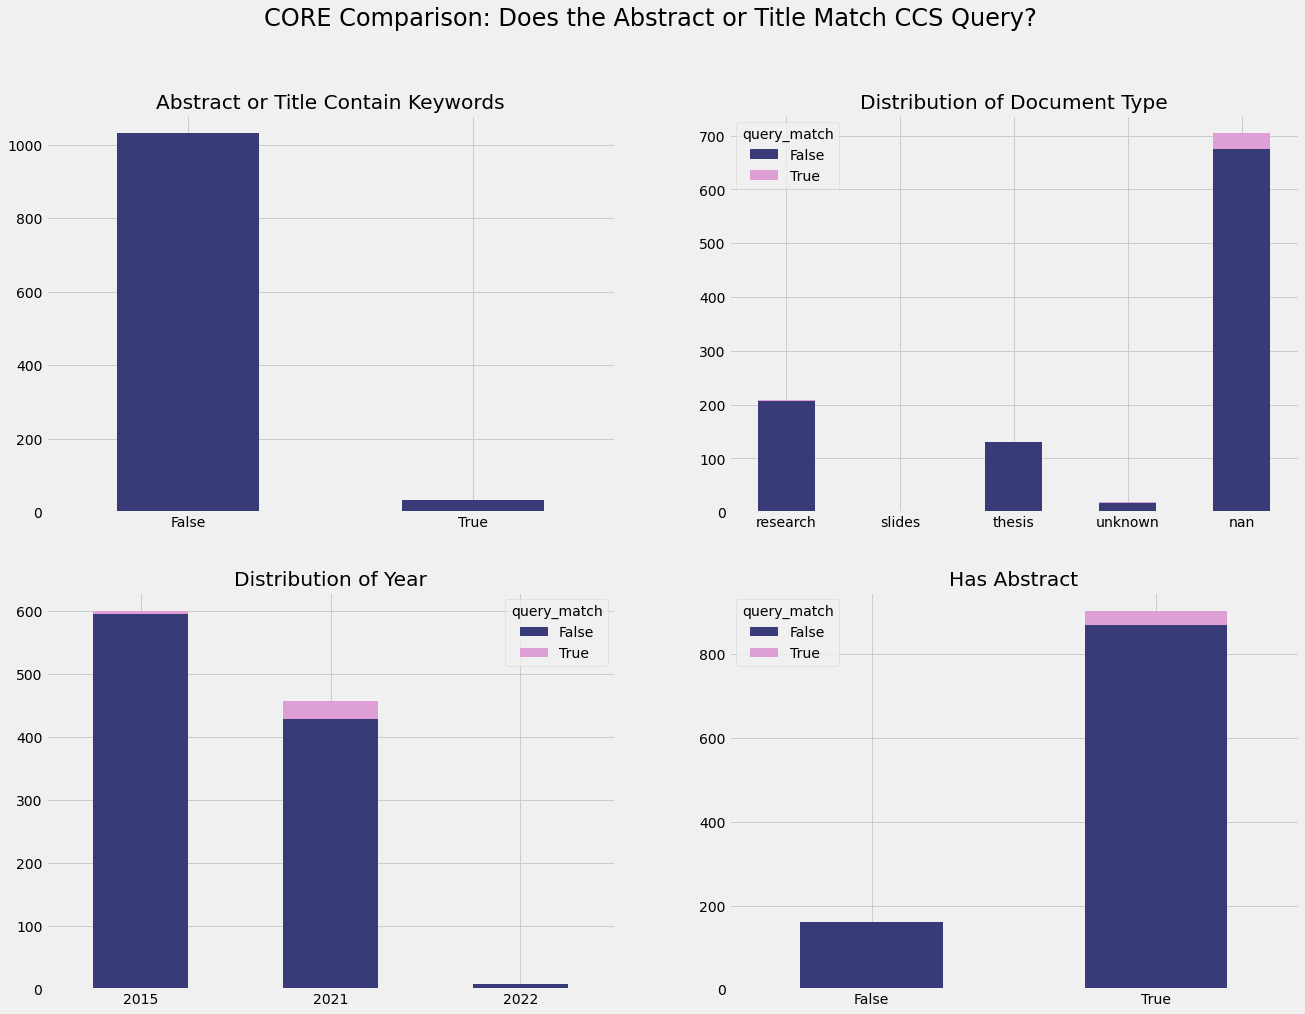

In [359]:
# Keywords in Abstract or Full Text Overview #

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,15))
plt.suptitle('CORE Comparison: Does the Abstract or Title Match CCS Query?', size=24)

df_q2_agg.groupby("query_match", dropna=False)["id"].agg("count")\
            .plot.bar(title="Abstract or Title Contain Keywords", xlabel="", rot=0, colormap="tab20b", ax=axes[0,0])

df_q2_agg.groupby(["query_match","documentType"], dropna=False)["id"].agg("count").unstack(level=0)\
            .plot.bar(title="Distribution of Document Type",xlabel="", colormap="tab20b", stacked=True, rot=0, ax=axes[0,1])

df_q2_agg.groupby(["query_match","pubyear"], dropna=False)["id"].agg("count").unstack(level=0)\
            .plot.bar(title="Distribution of Year",xlabel="", colormap="tab20b", stacked=True, rot=0, ax=axes[1,0])

df_q2_agg.groupby(["query_match","has_abstract"], dropna=False)["id"].agg("count").unstack(level=0)\
            .plot.bar(title="Has Abstract",xlabel="", colormap="tab20b", stacked=True, rot=0, ax=axes[1,1])

plt.savefig("../local/viz/doubleMatch/queryMatch_overview.png", bbox_inches="tight")

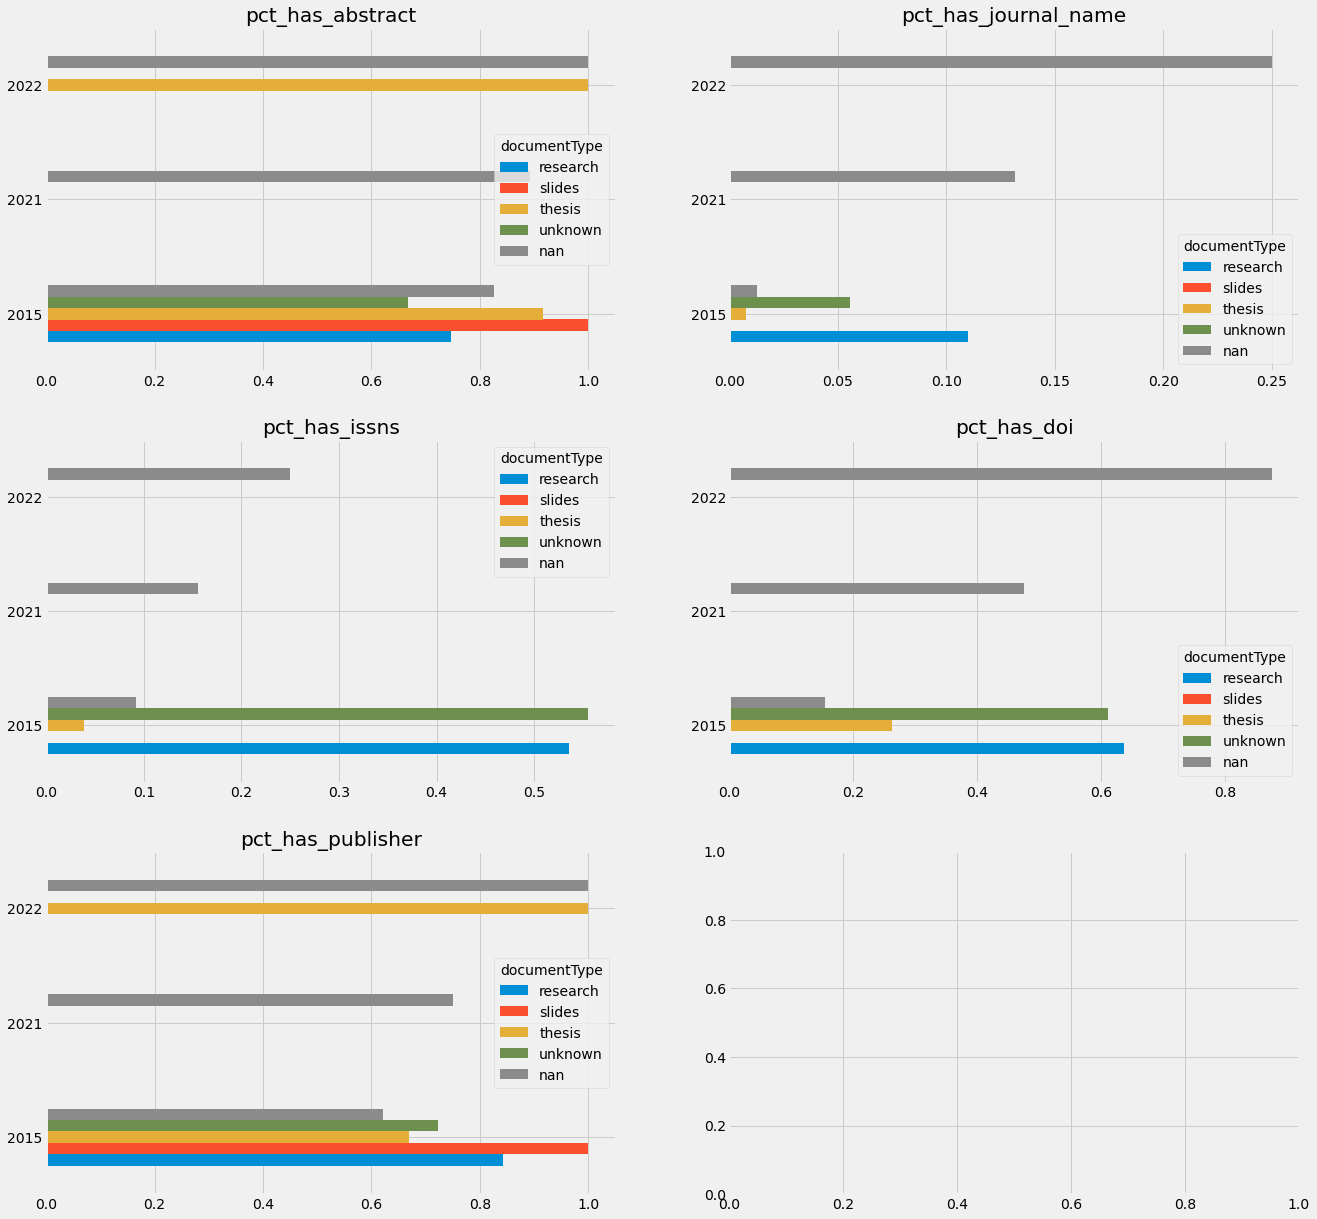

In [413]:
### Individual Doc Type Column Availability ###

df_docType = df_q2_agg.groupby(["pubyear","documentType"], dropna=False)[["has_abstract","has_journal_name","has_issns","has_doi","has_publisher","row_count"]]\
                        .agg(np.sum)

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20,20))

rw=0
col=0
for c in df_docType.columns:
    if c != "row_count":
        df_docType.assign(pct = df_docType[c]/df_docType["row_count"])\
          .loc[:,"pct"].unstack().plot.barh(title=f"pct_{c}", xlabel="", ylim=(0,1), ax=axes[rw,col])
        #plt.legend(loc="center", bbox_to_anchor=(1.1,0.5),ncol=1, fancybox=True)
        #plt.savefig(f"../local/viz/docType/pct_{c}.png", bbox_inches="tight")
        if col==1:
            col=0
            rw+=1
        else:
            col+=1
            
plt.savefig("../local/viz/docType/docType_overview.png", bbox_inches="tight")

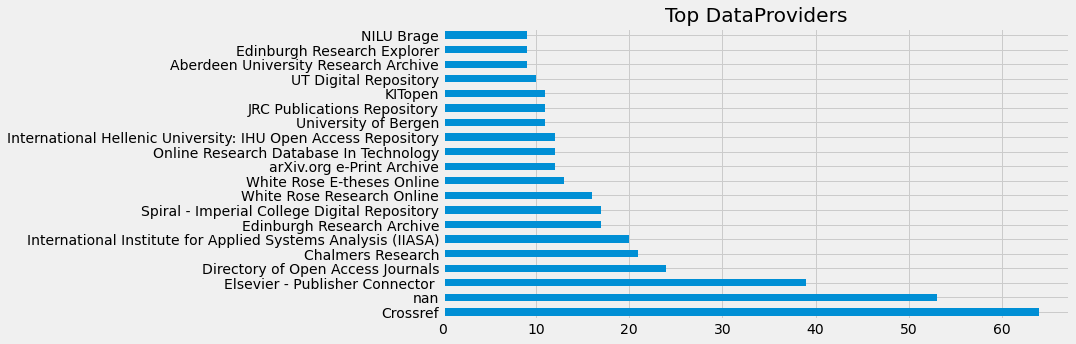

In [195]:
df_q2_agg.groupby("dataProviderName", dropna=False)["row_count"].agg("sum")\
    .reset_index().set_index("dataProviderName")\
    .sort_values(by="row_count", ascending=False).head(20)\
    .plot.barh(title="Top DataProviders", figsize=(10,5), xlabel="", ylabel="Documents", legend=None)
plt.savefig("../local/viz/top_dataproviders.png", bbox_inches="tight")

<AxesSubplot:title={'center':'Top DataProviders'}>

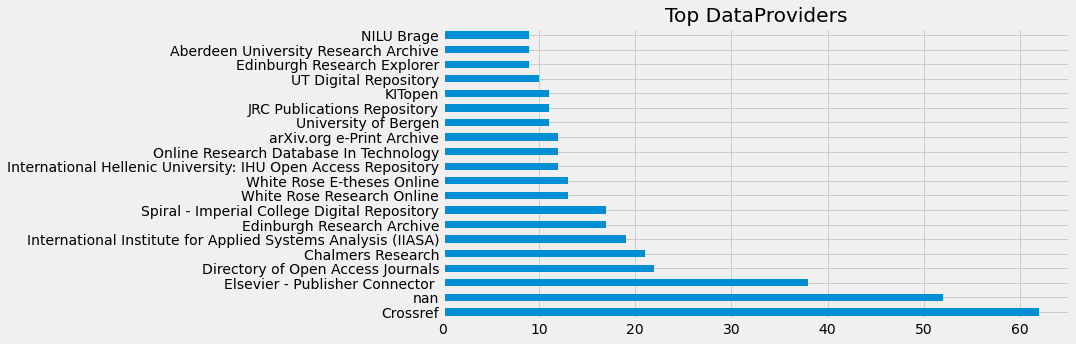

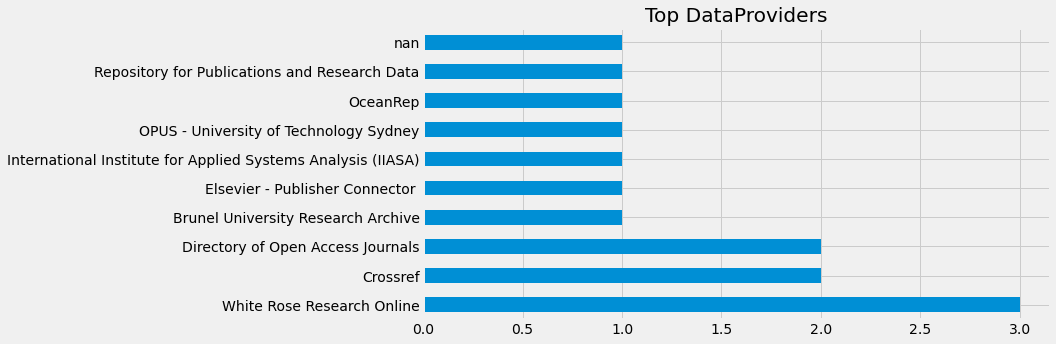

In [249]:
df_q2_agg.loc[~df_q2_agg["wos_match"]]\
        .groupby("dataProviderName", dropna=False)["row_count"].agg("sum")\
    .reset_index().set_index("dataProviderName")\
    .sort_values(by="row_count", ascending=False).head(20)\
    .plot.barh(title="Top DataProviders", figsize=(10,5), xlabel="", ylabel="Documents", legend=None)

df_q2_agg.loc[df_q2_agg["wos_match"]]\
        .groupby("dataProviderName", dropna=False)["row_count"].agg("sum")\
    .reset_index().set_index("dataProviderName")\
    .sort_values(by="row_count", ascending=False).head(20)\
    .plot.barh(title="Top DataProviders", figsize=(10,5), xlabel="", ylabel="Documents", legend=None)

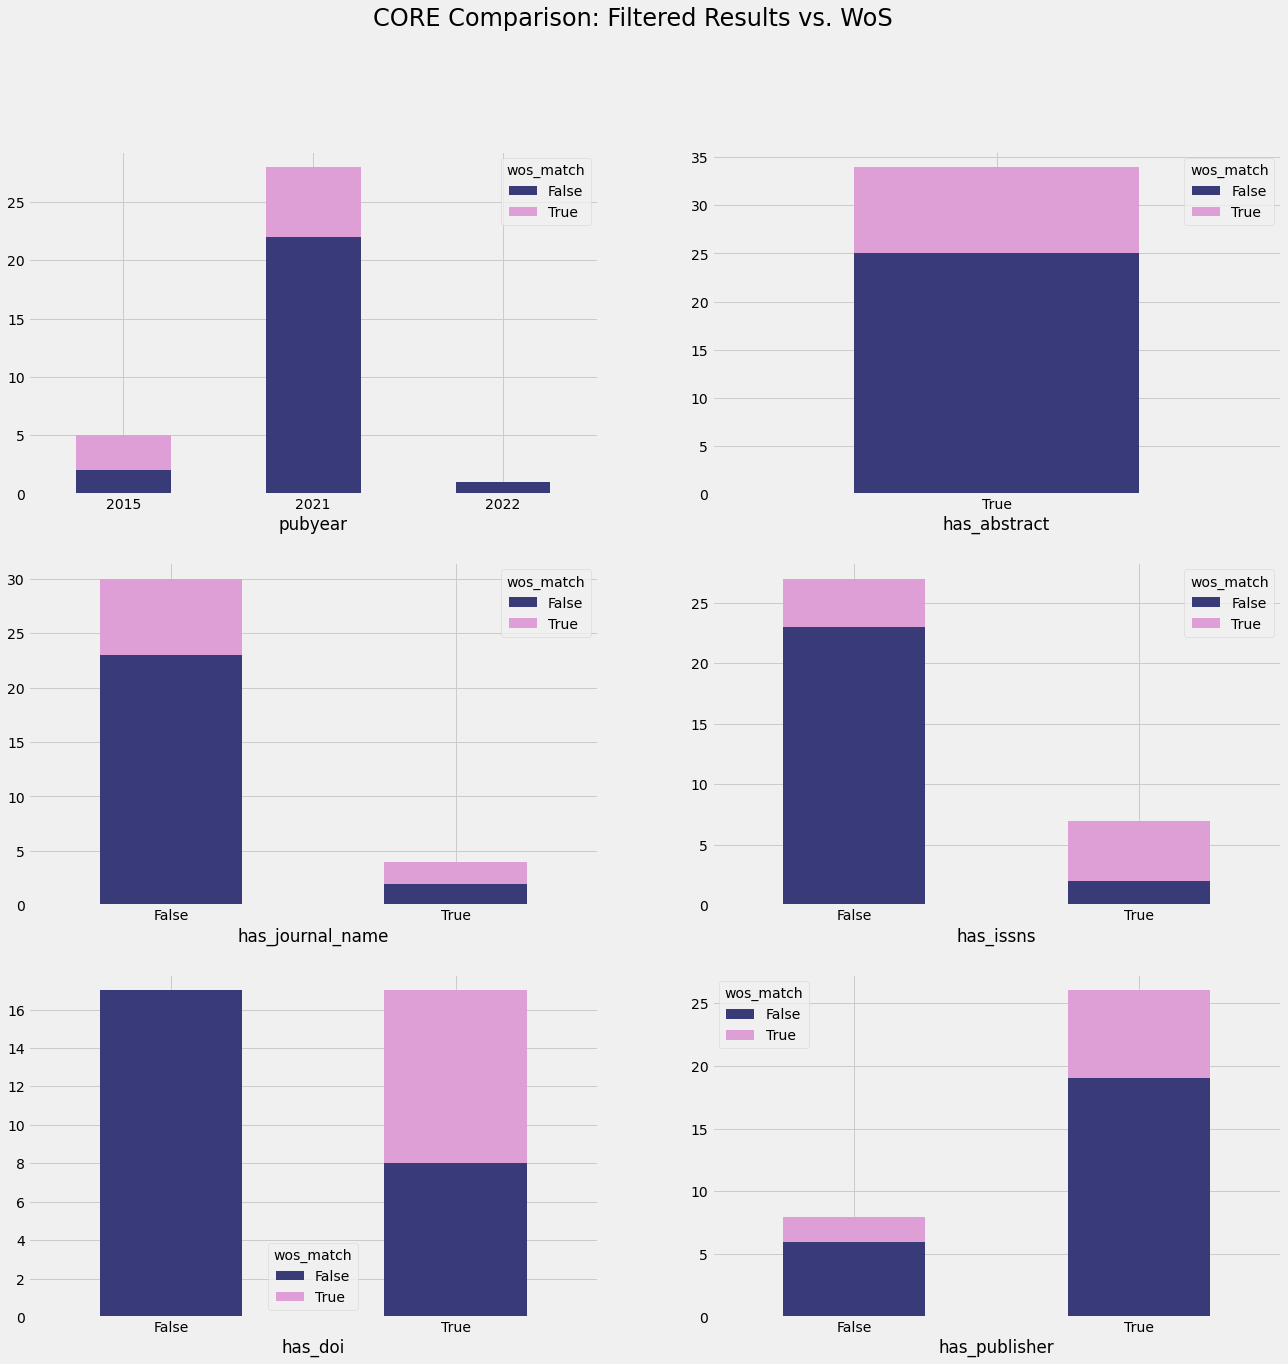

In [390]:
# Availability of Columns for Filtered Results vs. Wos #

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20,20))
plt.suptitle('CORE Comparison: Filtered Results vs. WoS', size=24)

rw = 0
col = 0
for c in df_q2_agg.columns:
    if ("has_" in c) or ("pubyear" in c):
        df_q2_agg.loc[df_q2_agg["query_match"]].groupby(["wos_match",c], dropna=False)["row_count"].agg("sum").unstack(level=0)\
                .plot.bar(colormap="tab20b", xlabel=c, stacked=True, rot=0, ax=axes[rw,col])
        if col==1:
            col=0
            rw+=1
        else:
            col+=1
    
plt.savefig("../local/viz/wosOverlap/filtered_vs_wos_overview.png", bbox_inches="tight")